<a href="https://colab.research.google.com/github/Zadak-H/Alzheimer-detection-and-classification-Using-Deep-Learning/blob/main/Alzheimer_detection_and_classification_Using_GANs_And_CNN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Deep Convolutional Generative Adversarial Network***


>*Generative Adversarial Networks (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A generator ("the artist") learns to create images that look real, while a discriminator ("the art critic") learns to tell real images apart from fakes. During training, the generator progressively becomes better at creating images that look real, while the discriminator becomes better at telling them apart. The process reaches equilibrium when the discriminator can no longer distinguish real images from fakes.*

### ***Our Proposed Method:-***


> *Firstly, GANs will be applied to generate some more images as a datatset, then if it is implemeted successfully then we will try SRGANs for getting better resolution and will use this as a data preprocessed.*







In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
import os

DATA_DIR = '/content/drive/MyDrive/Project_folder/Dataset/'
print(os.listdir(DATA_DIR))

['Non_Demented', 'Moderate_Demented', 'Very_Mild_Demented', 'Mild_Demented']


In [93]:
print(os.listdir(DATA_DIR+'/Mild_Demented')[:10])

['mild (582).jpg', 'mild (666).jpg', 'mild (933).jpg', 'mild (696).jpg', 'mild (759).jpg', 'mild (597).jpg', 'mild (984).jpg', 'mild (703).jpg', 'mild (948).jpg', 'mild (1114).jpg']


Let's load this dataset using the `ImageFolder` class from `torchvision`. We will also resize and crop the images to 64x64 px, and normalize the pixel values with a mean & standard deviation of 0.5 for each channel. This will ensure that pixel values are in the range `(-1, 1)`, which is more  convenient for training the discriminator. We will also create a data loader to load the data in batches.

In [94]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [95]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [96]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

Let's create helper functions to denormalize the image tensors and display some sample images from a training batch.

In [97]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [99]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

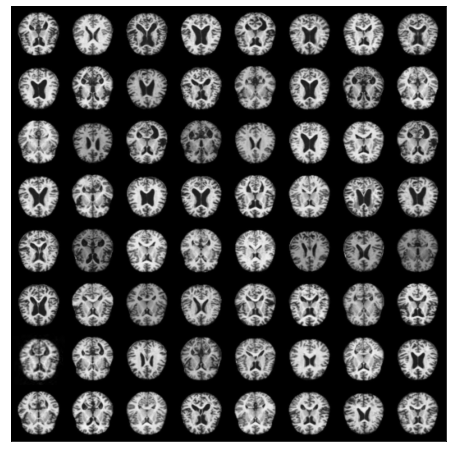

In [100]:
show_batch(train_dl)

In [101]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`).

In [102]:
device = get_default_device()
device

device(type='cuda')

We can now move our training data loader using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available).

In [103]:
train_dl = DeviceDataLoader(train_dl, device)

In [104]:
import torch.nn as nn

In [105]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [106]:
discriminator = to_device(discriminator, device)

In [107]:
latent_size = 128

In [108]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


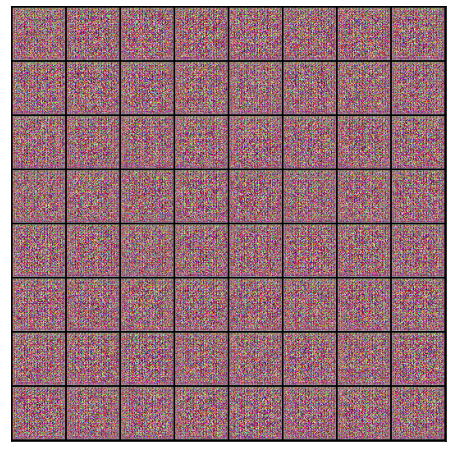

In [109]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

As one might expect, the output from the generator is basically random noise, since we haven't trained it yet. 

Let's move the generator to the chosen device.

In [110]:
generator = to_device(generator, device)

In [111]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [112]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model. We'll also create a helper function to export the generated images.

In [113]:
from torchvision.utils import save_image

In [114]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [115]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [116]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


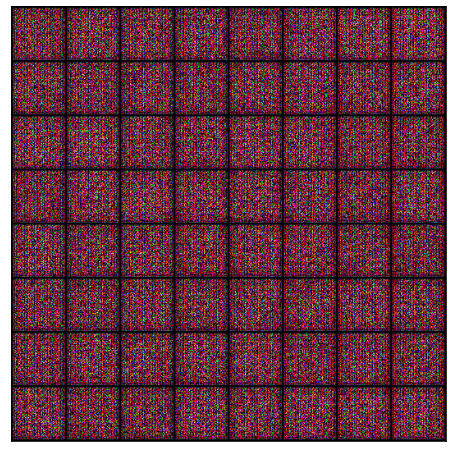

In [117]:
save_samples(0, fixed_latent)

## Full Training Loop

Let's define a `fit` function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>



In [118]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [119]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

We are now ready to train the model. Try different learning rates to see if you can maintain the fine balance between the training the generator and the discriminator.

In [160]:
lr = 0.0005
epochs = 50

In [161]:
history = fit(epochs, lr)

  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 3.8443, loss_d: 0.0895, real_score: 0.9616, fake_score: 0.0379
Saving generated-images-0001.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 4.7239, loss_d: 0.0644, real_score: 0.9820, fake_score: 0.0401
Saving generated-images-0002.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 4.5654, loss_d: 0.0581, real_score: 0.9633, fake_score: 0.0115
Saving generated-images-0003.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 5.3240, loss_d: 0.0295, real_score: 0.9817, fake_score: 0.0093
Saving generated-images-0004.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 5.4847, loss_d: 0.0359, real_score: 0.9706, fake_score: 0.0042
Saving generated-images-0005.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 6.5057, loss_d: 0.0195, real_score: 0.9930, fake_score: 0.0120
Saving generated-images-0006.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 5.7263, loss_d: 0.0394, real_score: 0.9745, fake_score: 0.0092
Saving generated-images-0007.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 6.4254, loss_d: 0.0254, real_score: 0.9888, fake_score: 0.0132
Saving generated-images-0008.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 7.2940, loss_d: 0.0330, real_score: 0.9742, fake_score: 0.0030
Saving generated-images-0009.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 5.2268, loss_d: 0.0710, real_score: 0.9730, fake_score: 0.0373
Saving generated-images-0010.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 5.6913, loss_d: 0.0411, real_score: 0.9860, fake_score: 0.0254
Saving generated-images-0011.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 5.2977, loss_d: 0.0382, real_score: 0.9863, fake_score: 0.0226
Saving generated-images-0012.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 4.7445, loss_d: 0.0742, real_score: 0.9741, fake_score: 0.0284
Saving generated-images-0013.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 5.7560, loss_d: 0.0397, real_score: 0.9818, fake_score: 0.0198
Saving generated-images-0014.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 5.6284, loss_d: 0.0326, real_score: 0.9747, fake_score: 0.0020
Saving generated-images-0015.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 5.9395, loss_d: 0.0468, real_score: 0.9783, fake_score: 0.0217
Saving generated-images-0016.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 4.6809, loss_d: 0.0515, real_score: 0.9760, fake_score: 0.0129
Saving generated-images-0017.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 6.7976, loss_d: 0.0254, real_score: 0.9941, fake_score: 0.0188
Saving generated-images-0018.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 5.6318, loss_d: 0.0906, real_score: 0.9560, fake_score: 0.0265
Saving generated-images-0019.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 5.3196, loss_d: 0.0444, real_score: 0.9869, fake_score: 0.0285
Saving generated-images-0020.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 5.9000, loss_d: 0.0306, real_score: 0.9881, fake_score: 0.0162
Saving generated-images-0021.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 5.9319, loss_d: 0.0257, real_score: 0.9853, fake_score: 0.0097
Saving generated-images-0022.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 4.6982, loss_d: 0.0672, real_score: 0.9621, fake_score: 0.0156
Saving generated-images-0023.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 4.9158, loss_d: 0.0457, real_score: 0.9763, fake_score: 0.0154
Saving generated-images-0024.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 5.3023, loss_d: 0.0459, real_score: 0.9712, fake_score: 0.0073
Saving generated-images-0025.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 6.3630, loss_d: 0.0331, real_score: 0.9863, fake_score: 0.0179
Saving generated-images-0026.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 7.5152, loss_d: 0.0276, real_score: 0.9802, fake_score: 0.0051
Saving generated-images-0027.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 6.3784, loss_d: 0.0865, real_score: 0.9466, fake_score: 0.0098
Saving generated-images-0028.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 5.6630, loss_d: 0.0278, real_score: 0.9800, fake_score: 0.0063
Saving generated-images-0029.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 7.4539, loss_d: 0.0516, real_score: 0.9922, fake_score: 0.0411
Saving generated-images-0030.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 5.6369, loss_d: 0.0370, real_score: 0.9797, fake_score: 0.0143
Saving generated-images-0031.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 5.4120, loss_d: 0.0297, real_score: 0.9862, fake_score: 0.0146
Saving generated-images-0032.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 5.3937, loss_d: 0.0560, real_score: 0.9843, fake_score: 0.0343
Saving generated-images-0033.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 5.7983, loss_d: 0.0510, real_score: 0.9858, fake_score: 0.0346
Saving generated-images-0034.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 5.5197, loss_d: 0.0481, real_score: 0.9795, fake_score: 0.0224
Saving generated-images-0035.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 6.3572, loss_d: 0.0418, real_score: 0.9819, fake_score: 0.0220
Saving generated-images-0036.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 6.6843, loss_d: 0.0280, real_score: 0.9908, fake_score: 0.0180
Saving generated-images-0037.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 6.3110, loss_d: 0.0207, real_score: 0.9931, fake_score: 0.0133
Saving generated-images-0038.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 5.0561, loss_d: 0.0432, real_score: 0.9882, fake_score: 0.0291
Saving generated-images-0039.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 7.6151, loss_d: 0.0251, real_score: 0.9926, fake_score: 0.0172
Saving generated-images-0040.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 6.1930, loss_d: 0.0357, real_score: 0.9773, fake_score: 0.0108
Saving generated-images-0041.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 7.3687, loss_d: 0.0463, real_score: 0.9913, fake_score: 0.0344
Saving generated-images-0042.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 6.6077, loss_d: 0.1201, real_score: 0.9153, fake_score: 0.0005
Saving generated-images-0043.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 8.3996, loss_d: 0.0793, real_score: 0.9943, fake_score: 0.0621
Saving generated-images-0044.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 5.2094, loss_d: 0.0429, real_score: 0.9723, fake_score: 0.0123
Saving generated-images-0045.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 4.7105, loss_d: 0.1039, real_score: 0.9476, fake_score: 0.0119
Saving generated-images-0046.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 8.0762, loss_d: 0.1165, real_score: 0.9287, fake_score: 0.0023
Saving generated-images-0047.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 6.7199, loss_d: 0.0853, real_score: 0.9732, fake_score: 0.0509
Saving generated-images-0048.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 6.5982, loss_d: 0.0372, real_score: 0.9809, fake_score: 0.0154
Saving generated-images-0049.png


  0%|          | 0/54 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 4.9712, loss_d: 0.0475, real_score: 0.9669, fake_score: 0.0104
Saving generated-images-0050.png


In [162]:
losses_g, losses_d, real_scores, fake_scores = history

Now that we have trained the models, we can save checkpoints.

In [163]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

Here's how the generated images look, after the 1st, 5th and 10th epochs of training.

In [164]:
from IPython.display import Image

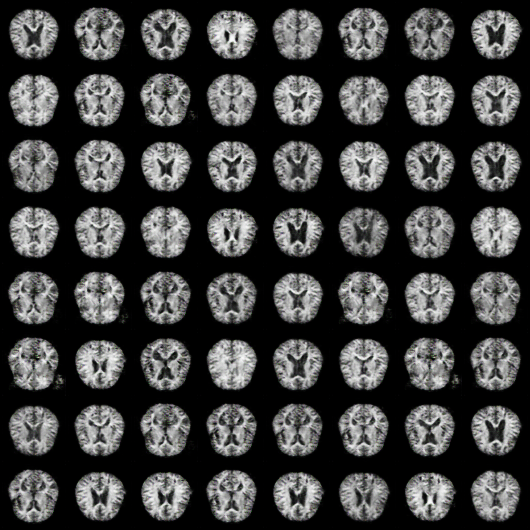

In [165]:
Image('./generated/generated-images-0001.png')

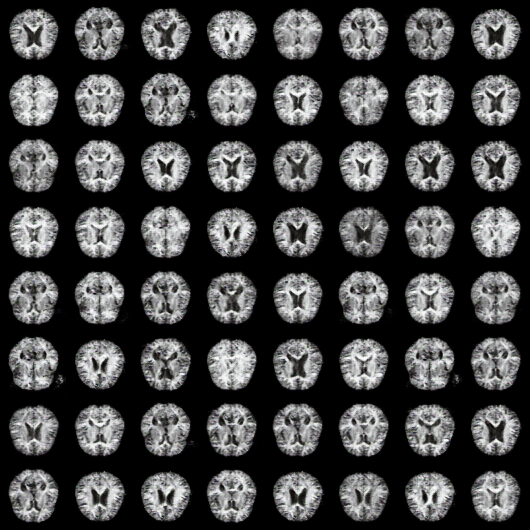

In [166]:
Image('./generated/generated-images-0005.png')

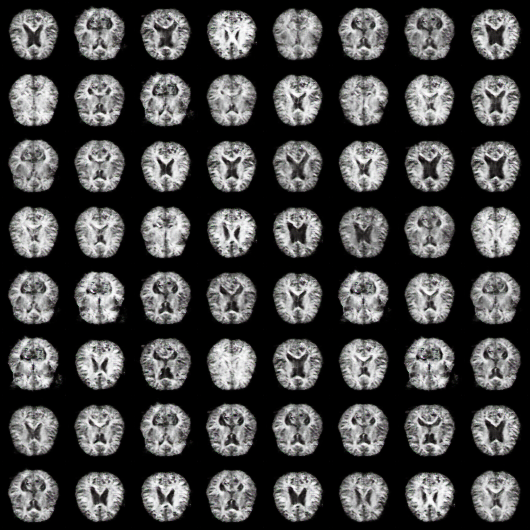

In [167]:
Image('./generated/generated-images-0010.png')

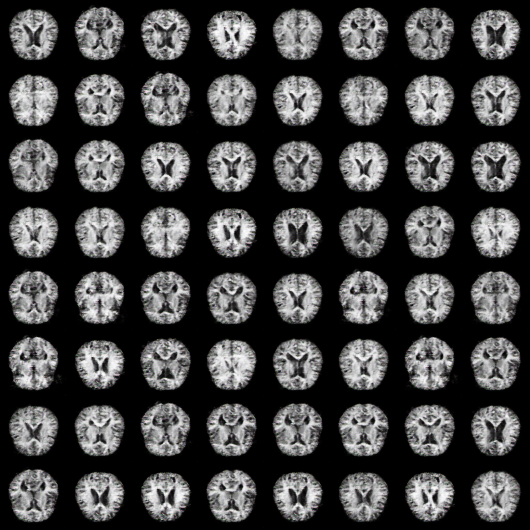

In [168]:
Image('./generated/generated-images-0015.png')

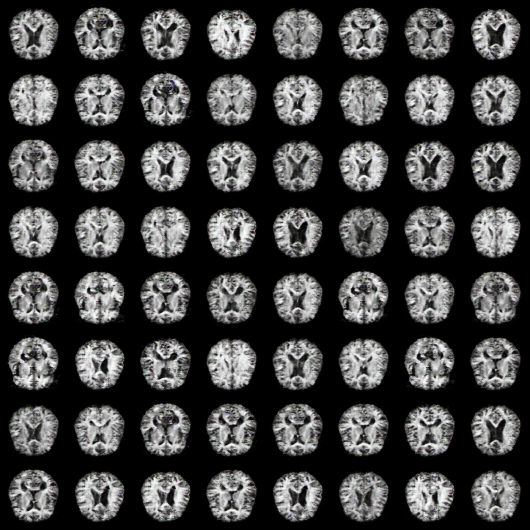

In [169]:
Image('./generated/generated-images-0020.png')

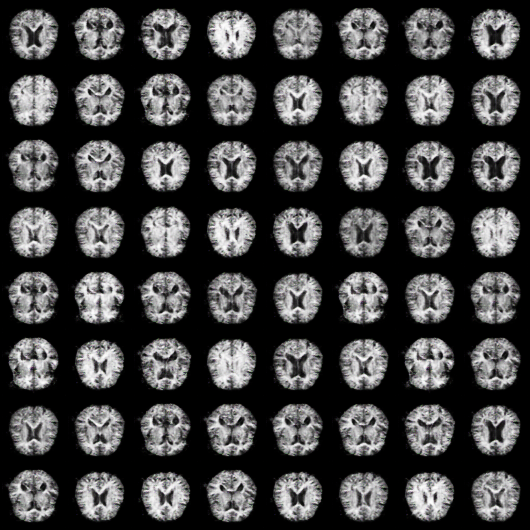

In [170]:
Image('./generated/generated-images-0025.png')

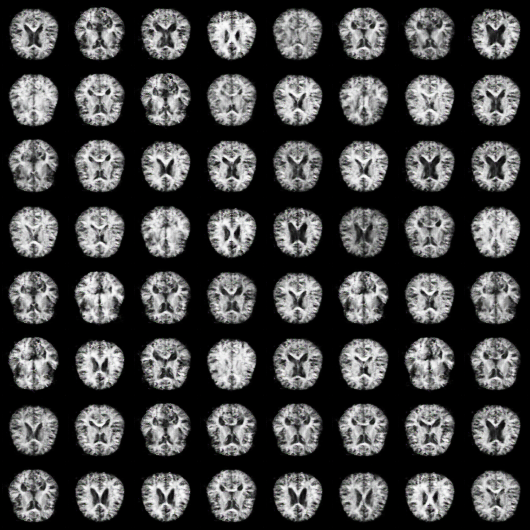

In [171]:
Image('./generated/generated-images-0030.png')

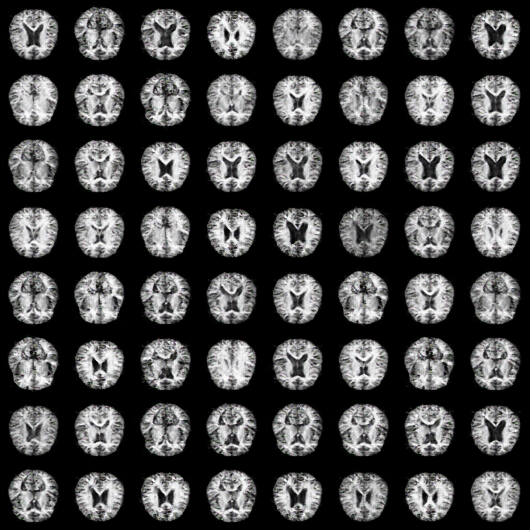

In [172]:
Image('./generated/generated-images-0035.png')

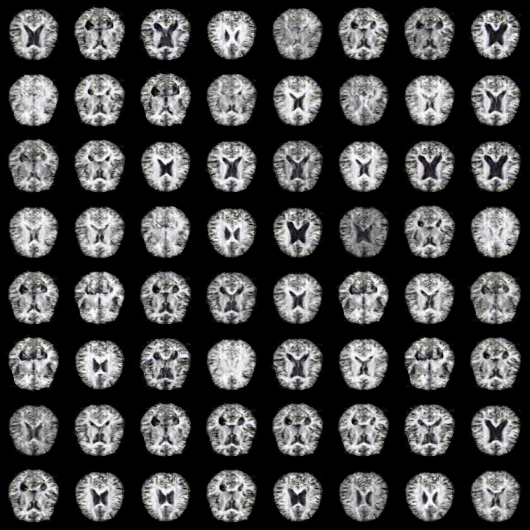

In [173]:
Image('./generated/generated-images-0040.png')

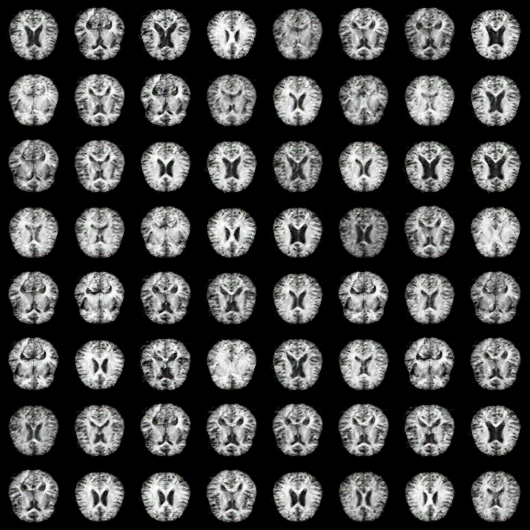

In [174]:
Image('./generated/generated-images-0050.png')

We can visualize the training process by combining the sample images generated after each epoch into a video using OpenCV.

In [175]:
import cv2
import os

vid_fname = 'gans_training.mp4'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()


We can also visualize how the loss changes over time. Visualizing 
losses is quite useful for debugging the training process. For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high.



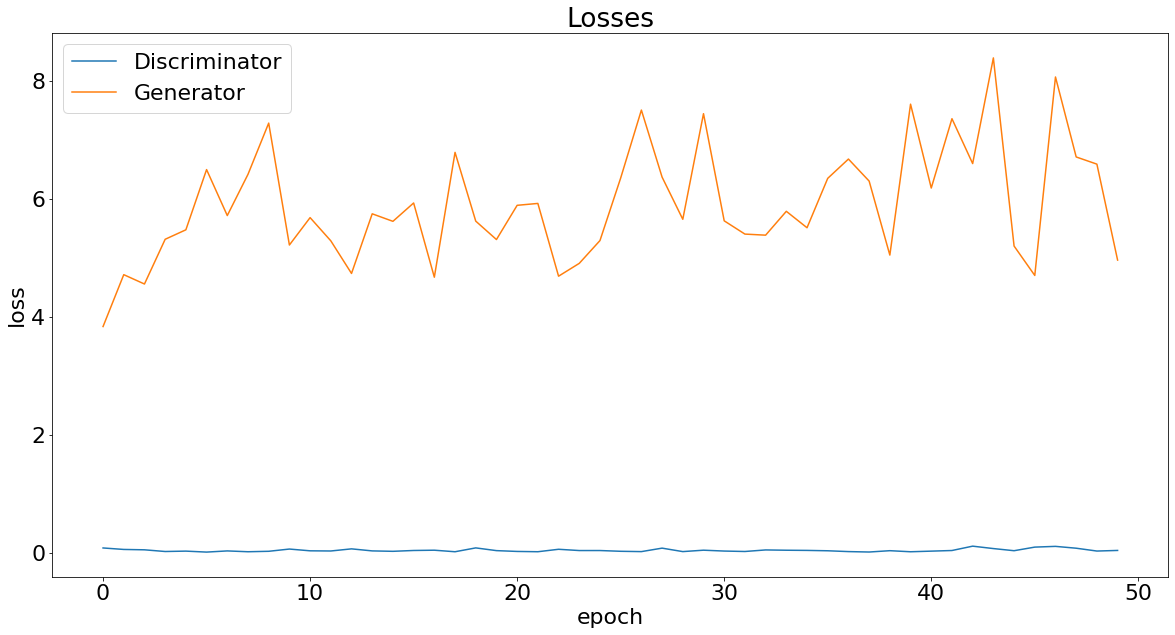

In [176]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22}) 
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

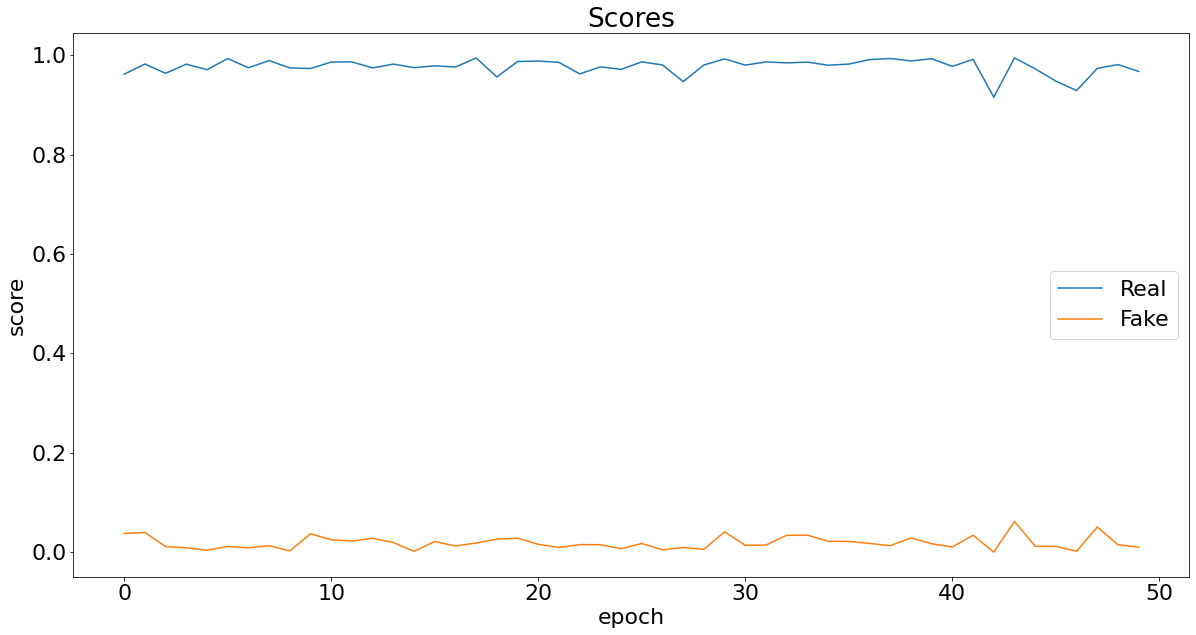

In [177]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22}) 
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');